In [1]:
%%capture
# tensorflow:
import tensorflow as tf
from multiprocessing import cpu_count
config = tf.ConfigProto(log_device_placement=True, device_count = {'CPU': cpu_count()})
session = tf.Session(config=config)
import numpy as np
np.set_printoptions(suppress=True) # no exponential print
import pandas as pd
pd.set_option('max_columns', 300)
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os

# Keras
import keras.backend as K
K.set_session(session)
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img # Image Preprocessing
from keras import layers, models, callbacks
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Lambda
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard, Callback
from keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras.layers.advanced_activations import LeakyReLU

In [2]:
RUN_NAME  = '04.01.19_2' ######################################## UPDATE THIS ########################################

LABELS_DIR = "D:\\OneDrive - studium.uni-hamburg.de\\Programmierung\\Python\\Kaggle\\GalaxyZoo\\"
TRAIN_DIR  = "C:\\ML-Datasets\\\GalaxyZoo\\train\\"
TEST_DIR   = "C:\\ML-Datasets\\\GalaxyZoo\\test\\"

NET_FOLDER   = 'MyNet\\'
IMG_SIZE     = (224, 224)
DATA_TYPE = ".jpg"
    
WEIGHTS_DIR = LABELS_DIR + 'results_and_weights\\' + NET_FOLDER

# create run folder:
if not os.path.exists(WEIGHTS_DIR + RUN_NAME): 
    os.makedirs(WEIGHTS_DIR + RUN_NAME)

Size of the images: (224, 224)


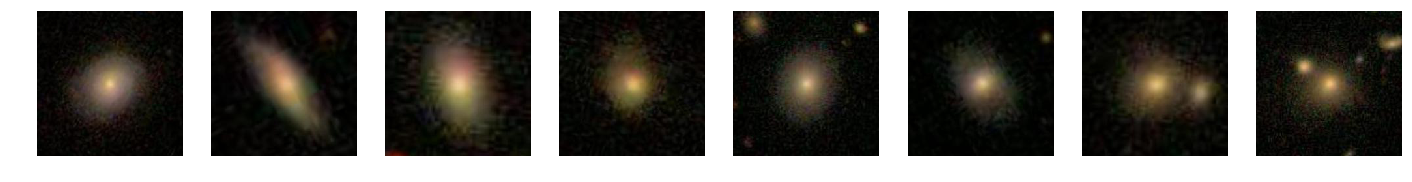

In [3]:
# if sys.platform != 'win32': # MacOS oder Linux
filelist = os.listdir(TRAIN_DIR)

plt.figure(num=None, figsize=(22, 20), dpi=80)
for i,file in enumerate(filelist[:8]):
    plt.subplot(1,8,i+1)
    img = load_img(TRAIN_DIR+file)    # this is a PIL image
    plt.imshow(img)
    plt.axis('off')
print("Size of the images:",img.size)

As we can see the region of interest (the current galaxy) is always in the center of the image. A Problem could be the surrounding galaxies and stars so maybe later I can do some preprocessing that paints these black.

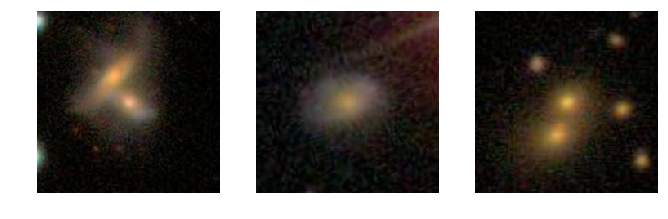

In [4]:
''' Example Problems: '''
problem_pictures = [100263,100445,100458]
plt.figure(num=None, figsize=(10, 15), dpi=80)
for i,pic in enumerate(problem_pictures):
    plt.subplot(1,len(problem_pictures),i+1)
    img = load_img(TRAIN_DIR+str(pic)+".jpg")
    plt.imshow(img)
    plt.axis('off')

In [5]:
''' import the labels (class probabilities)'''
labels = pd.read_csv(LABELS_DIR + "training_solutions_rev1.csv")      # Get the description table (ID's and Labels)
print(labels.shape[1]-1,"features and",labels.shape[0],"images")      # Print amount of Features and Images
labels.head()

37 features and 61578 images


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [6]:
''' Split into training and validation set '''
from sklearn.model_selection import train_test_split
train_labels, valid_labels = train_test_split(labels, test_size=0.10, random_state=43)
print(train_labels.shape, valid_labels.shape)

(55420, 38) (6158, 38)


In [7]:
################### TRAIN CONST: ###################
BATCH_SIZE  = 64           # higher batch size to utilize the GPU # 32, 64, 128
EPOCHS      = 100          # how often the dataset is shown to the network. High values might lead to overfitting.
DROPOUT     = 0.4
LEARN_RATE  = 1e-4

In [8]:
# to process colored images faster, only use these augmentations:
train_args =  dict(rescale=1./255, 
                   rotation_range = 355, 
                   horizontal_flip = True, 
                   vertical_flip = True,
                   # shear_range = 0.02,
                   width_shift_range = 0.01,
                   # height_shift_range = 0.01,
                   zoom_range = [0.9, 1.1],
                   data_format = 'channels_last')

valid_args = dict(rescale=1./255,
                  fill_mode = 'reflect',
                  data_format = 'channels_last')
train_gen = ImageDataGenerator(**train_args)
valid_gen = ImageDataGenerator(**valid_args)
# featurewise_center maybe True?? 

In [9]:
flow_args = dict(directory  = TRAIN_DIR,
                 class_mode  = 'sparse',
                 target_size = IMG_SIZE,
                 color_mode  = 'rgb')

train_generator = train_gen.flow_from_directory(**flow_args, shuffle = True, batch_size = BATCH_SIZE)
train_generator.filenames   = np.array([str(img_id)+DATA_TYPE for img_id in train_labels['GalaxyID'].values])
train_generator.classes     = train_labels.drop('GalaxyID', axis=1).values
train_generator.samples     = train_labels.shape[0]
train_generator.n           = train_labels.shape[0]

valid_generator = valid_gen.flow_from_directory(**flow_args, shuffle = False, batch_size = 6158) # one big batch
valid_generator.filenames = np.array([str(img_id)+DATA_TYPE for img_id in valid_labels['GalaxyID'].values])
valid_generator.classes   = valid_labels.drop('GalaxyID', axis=1).values
valid_generator.samples   = valid_labels.shape[0]
valid_generator.n         = valid_labels.shape[0]

print("Ignore prints above. The generators got setup correctly.")

# used a fixed dataset for evaluating the algorithm
valid_generator_x, valid_generator_y = next(valid_generator)# x=images, y=labels
print("Big validation batch shape:", valid_generator_x.shape, valid_generator_y.shape)

# print shape of training batch:
example_train_batch = train_generator.next()
print("Training batch shape:",example_train_batch[0].shape, example_train_batch[1].shape)  # [0]=images, [1]=labels
train_generator.reset()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Ignore prints above. The generators got setup correctly.
Big validation batch shape: (6158, 224, 224, 3) (6158, 37)
Training batch shape: (64, 224, 224, 3) (64, 37)


[0.007866   0.992134   0.         0.01624223 0.97589177 0.37244422
 0.60344756 0.92931734 0.04657443 0.07852416 0.32672564 0.28662429
 0.28401769 0.973017   0.026983   0.00467255 0.00319345 0.
 0.11217913 0.06053041 0.         0.         0.13715745 0.66315001
 0.         0.         0.01624223 0.         0.25386348 0.39081883
 0.28463503 0.         0.34719482 0.28881603 0.10183367 0.
 0.19147376]


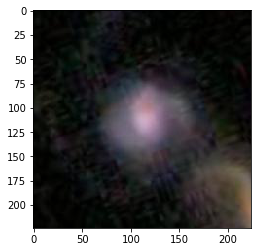

In [10]:
plt.imshow(valid_generator_x[11,:,:])
print(valid_generator_y[11])

<BarContainer object of 37 artists>

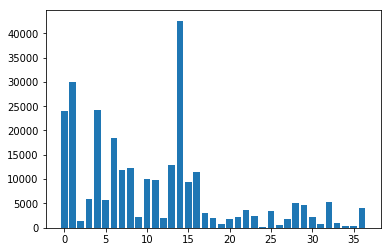

In [11]:
occurrence = np.sum(train_labels.drop('GalaxyID',axis=1))
plt.bar(np.arange(labels.shape[1]-1), occurrence)

As shown in the figure above, the occurence of galaxy classes is pretty imbalanced. Since the Kaggle metric is mean squared loss, ignoring this might not even effect the result. Ways of dealing with this would be oversampling or class weights.

In [12]:
img_shape       = (IMG_SIZE[0], IMG_SIZE[1], 3)
img_in          = layers.Input(img_shape, name='RGB-In')

orthogonal_init = Orthogonal(gain=1.0, seed=43)
'''  CNN-Layers   ''' 
# AlexNet (changed strides first layer 4->3)
conv_1          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3))(Conv2D(96, (6,6), strides=2, activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(img_in)))
conv_2          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3), strides=2)(Conv2D(256, (3,3),  activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_1)))
conv_3          = BatchNormalization()(Conv2D(384, (3,3), activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_2))
conv_4          = BatchNormalization()(Conv2D(384, (3,3), activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_3))
conv_5          = BatchNormalization()(MaxPooling2D(pool_size=(3, 3), strides=2)(Conv2D(256, (3,3),  activation = 'relu', kernel_initializer=orthogonal_init, padding='same')(conv_4)))
flatten         = Flatten()(conv_5)

'''   Dense Layers   '''
dense_1         = Dense(128, kernel_initializer=orthogonal_init, activation = 'linear')(flatten) # , activation = 'relu'
activation_1    = LeakyReLU(alpha=.01)(dense_1)
dropout_1       = Dropout(DROPOUT)(dense_1)
bn_6            = BatchNormalization()(dropout_1)

dense_2         = Dense(50, kernel_initializer=orthogonal_init, activation = 'linear')(bn_6) # , activation = 'relu'
activation_2    = LeakyReLU(alpha=.01)(dense_2)
dropout_2       = Dropout(DROPOUT)(activation_2)
bn_7            = BatchNormalization()(dropout_2)

out_layer       = Dense(labels.shape[1]-1, activation = 'sigmoid')(bn_7) # 37 classes

'''   Define and compile Model   '''
galaxy_model   = models.Model(inputs = [img_in], outputs = [out_layer], name = 'galaxy_model')
galaxy_model.compile(loss      = 'mean_squared_error',
                      optimizer = Adam(lr=LEARN_RATE),
                      metrics   = ['acc', 'binary_crossentropy'])
galaxy_model.summary()
# possible additional layers:
# img_noise       = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
# feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features) # drops entire filter layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RGB-In (InputLayer)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 96)      10464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 256)       221440    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 256)       1024      
__________

<h2>Train Callbacks</h2>

In [13]:
class save_hist_cal(Callback):
    def __init__(self,**kargs):
        if os.path.isfile(WEIGHTS_DIR + RUN_NAME + '\\' + "training_log.npy"): # training continued
            self.all_logs = np.load(WEIGHTS_DIR + RUN_NAME + '\\' + "training_log.npy")
        else:
            self.all_logs = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[], 'f1_score':[], 'val_f1_score':[]} # add LR
        
    def on_epoch_end(self, epoch, logs={}): # things done on end of the epoch
        for metric in self.all_logs:
            self.all_logs[metric].append(logs.get(metric))
        np.save(WEIGHTS_DIR + RUN_NAME + '\\' + "training_log", self.all_logs)
        # it's possible to save model weights after each epoch here

# run this only once:
save_hist = save_hist_cal()
save_hist.__init__()

In [14]:
# saves weights after each epoch:
checkpoint = ModelCheckpoint(WEIGHTS_DIR + RUN_NAME + '\\' + 'best.weights.hdf5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# reduce learning_rate on loss plateau:  # 1 epoch without val_loss improvement -> decrease LR
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=1, min_lr=1e-9)

# early stopping (avoid overfitting):
early = EarlyStopping(monitor="val_loss", mode="min", patience=5) # 5 (between 5 and 12) epochs without val_loss improvement -> stop

# save log for tensorboard:
tf_board = TensorBoard(log_dir=WEIGHTS_DIR + RUN_NAME + '\\' + 'logs', batch_size=BATCH_SIZE)

callbacks_list = [checkpoint, reduceLROnPlat, early, tf_board, save_hist] # save_hist

<h1> Training </h1>

In [15]:
train_generator.batch_size = BATCH_SIZE # use this without reinitializing the train_generator
train_generator.reset()

''' Continuing training overwrites the weights! Make a backup!'''

galaxy_model.fit_generator( train_generator,
                            steps_per_epoch = train_generator.samples//BATCH_SIZE,
                            validation_data = (valid_generator_x, valid_generator_y),
                            epochs          = EPOCHS,
                            callbacks       = callbacks_list,
                            workers         = cpu_count() )
                            # class_weight    = class_weights )


Epoch 1/100
865/865 [==============================] - 176s 203ms/step - loss: 0.1612 - acc: 0.3241 - binary_crossentropy: 0.7496 - val_loss: 0.1031 - val_acc: 0.6254 - val_binary_crossentropy: 0.7887

Epoch 00001: val_loss improved from inf to 0.10309, saving model to D:\OneDrive - studium.uni-hamburg.de\Programmierung\Python\Kaggle\GalaxyZoo\results_and_weights\MyNet\04.01.19_2\best.weights.hdf5
Epoch 2/100
865/865 [==============================] - 172s 199ms/step - loss: 0.0885 - acc: 0.5699 - binary_crossentropy: 0.7605 - val_loss: 0.0393 - val_acc: 0.6158 - val_binary_crossentropy: 0.4168

Epoch 00002: val_loss improved from 0.10309 to 0.03935, saving model to D:\OneDrive - studium.uni-hamburg.de\Programmierung\Python\Kaggle\GalaxyZoo\results_and_weights\MyNet\04.01.19_2\best.weights.hdf5
Epoch 3/100
865/865 [==============================] - 172s 199ms/step - loss: 0.0601 - acc: 0.5808 - binary_crossentropy: 0.6623 - val_loss: 0.0365 - val_acc: 0.6064 - val_binary_crossentropy: 

865/865 [==============================] - 171s 198ms/step - loss: 0.0135 - acc: 0.7374 - binary_crossentropy: 0.2581 - val_loss: 0.0129 - val_acc: 0.7595 - val_binary_crossentropy: 0.2560

Epoch 00024: val_loss did not improve from 0.01206

Epoch 00024: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
Epoch 25/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0132 - acc: 0.7407 - binary_crossentropy: 0.2569 - val_loss: 0.0110 - val_acc: 0.7892 - val_binary_crossentropy: 0.2481

Epoch 00025: val_loss improved from 0.01206 to 0.01095, saving model to D:\OneDrive - studium.uni-hamburg.de\Programmierung\Python\Kaggle\GalaxyZoo\results_and_weights\MyNet\04.01.19_2\best.weights.hdf5
Epoch 26/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0130 - acc: 0.7413 - binary_crossentropy: 0.2563 - val_loss: 0.0120 - val_acc: 0.7629 - val_binary_crossentropy: 0.2510

Epoch 00026: val_loss did not improve from 0.01095
Epoch 27/100
865/8

865/865 [==============================] - 171s 198ms/step - loss: 0.0119 - acc: 0.7483 - binary_crossentropy: 0.2525 - val_loss: 0.0099 - val_acc: 0.7965 - val_binary_crossentropy: 0.2442

Epoch 00048: val_loss did not improve from 0.00986
Epoch 49/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0119 - acc: 0.7468 - binary_crossentropy: 0.2527 - val_loss: 0.0099 - val_acc: 0.8019 - val_binary_crossentropy: 0.2440

Epoch 00049: val_loss did not improve from 0.00986
Epoch 50/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0118 - acc: 0.7472 - binary_crossentropy: 0.2522 - val_loss: 0.0099 - val_acc: 0.8004 - val_binary_crossentropy: 0.2441

Epoch 00050: val_loss did not improve from 0.00986

Epoch 00050: ReduceLROnPlateau reducing learning rate to 2.7993597541353666e-06.
Epoch 51/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0119 - acc: 0.7479 - binary_crossentropy: 0.2522 - val_loss: 0.0098 - val_acc: 0.8035 -

865/865 [==============================] - 171s 198ms/step - loss: 0.0118 - acc: 0.7479 - binary_crossentropy: 0.2523 - val_loss: 0.0098 - val_acc: 0.8038 - val_binary_crossentropy: 0.2436

Epoch 00074: val_loss did not improve from 0.00980

Epoch 00074: ReduceLROnPlateau reducing learning rate to 4.7018491500239175e-08.
Epoch 75/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0118 - acc: 0.7487 - binary_crossentropy: 0.2521 - val_loss: 0.0098 - val_acc: 0.8043 - val_binary_crossentropy: 0.2438

Epoch 00075: val_loss did not improve from 0.00980
Epoch 76/100
865/865 [==============================] - 171s 198ms/step - loss: 0.0119 - acc: 0.7471 - binary_crossentropy: 0.2523 - val_loss: 0.0098 - val_acc: 0.8055 - val_binary_crossentropy: 0.2437

Epoch 00076: val_loss improved from 0.00980 to 0.00979, saving model to D:\OneDrive - studium.uni-hamburg.de\Programmierung\Python\Kaggle\GalaxyZoo\results_and_weights\MyNet\04.01.19_2\best.weights.hdf5
Epoch 77/100
865/

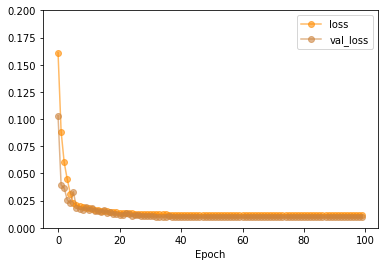

In [16]:
train_hist_curr = np.load(WEIGHTS_DIR + RUN_NAME  + '\\' + "training_log.npy")
loss, val_loss, acc, val_acc = [train_hist_curr.item()[item] for item in ['loss', 'val_loss', 'acc', 'val_acc']]
plt.plot(list(range(len(loss))),     loss,'-o', color="darkorange", label='loss', alpha=0.6)
plt.plot(list(range(len(val_loss))), val_loss,'-o', color="peru",label='val_loss', alpha=0.6)
plt.xlabel("Epoch")
plt.ylim(0,0.2)
plt.legend()
plt.show()